In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from copy import deepcopy
import glob
import sys

[sys.path.append(f) for f in glob.glob('../utils/*')]
from preprocess import DataStruct
from plotting_utils import figSize
from lineplots import plotsd
from hmm_utils import *
from hmm import *
from session_utils import *
from recalibration_utils import *
from click_utils import *

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import FactorAnalysis, PCA


files          = glob.glob('D:/T5_ClosedLoop/historical/*')
sessions_check = np.load('../utils/misc_data/OldSessions_check.npy', allow_pickle = True).item()
sessions_check['bad_days'].append('D:/T5_ClosedLoop/historical\\t5.2016.10.13.mat') # drop bad click decoder day


min_nblocks    = 3       # min number of blocks for a session to be include
max_ndays      = 1e23    # accept all pairs of sessions regardless of time between
min_R2         = 0.1     # subselect days with good decoder performance 

# get click sessions:
click_sessions = get_Sessions(files, min_nblocks, getClick = True)                 

# get pairs of click sessions:
init_pairs    = get_SessionPairs(click_sessions, max_ndays = max_ndays, manually_remove = sessions_check['bad_days'])
pairs, scores = get_StrongTransferPairs(init_pairs, min_R2 = min_R2, train_size = 0.5, block_constraints = sessions_check)
n_pairs       = len(pairs)

In [19]:
np.concatenate(train_x).shape

(30292, 192)

### Example recalibration comparison

In [39]:
i = 1

dayA = DataStruct(pairs[i][0], alignScreens = True)


# Get initial day performance and decoder:
train_frac = 0.5
task       = None
sigma      = None
blocks     = None

train_x, test_x, train_y, test_y  = getTrainTest(dayA, train_size = train_frac, sigma = sigma, task = task, blocks = blocks, returnFlattened = True)

#train_x = np.concatenate(train_x)
#test_x  = np.concatenate(test_x)
#train_y = np.concatenate(train_y)
#test_y = np.concatenate(test_y)


#ref_scores, ref_decoder           = traintest_DecoderSupervised([train_x], [test_x], [train_y], [test_y])
ref_scores, ref_decoder           = traintest_DecoderSupervised([train_x], [test_x], [train_y], [test_y])


train_x, test_x, train_y, test_y  = get_T5_ClickTrainTest(dayA, train_frac = train_frac)
ref_classifier                    = ClickDecoder(window = 20, n_components = 5).train(train_x - train_x.mean(axis = 0), train_y)


print('Velocity decoder performance on day A: R^2 = ', np.mean(ref_scores))
print('Click decoder performance on day A: var(delta) = ', np.var(ref_classifier.score_delta(test_x - train_x.mean(axis = 0), test_y)))

Velocity decoder performance on day A: R^2 =  0.365153398873318
Click decoder performance on day A: var(delta) =  42069.690358114865


In [47]:
preds = ref_classifier.predict(test_x - train_x.mean(axis = 0))

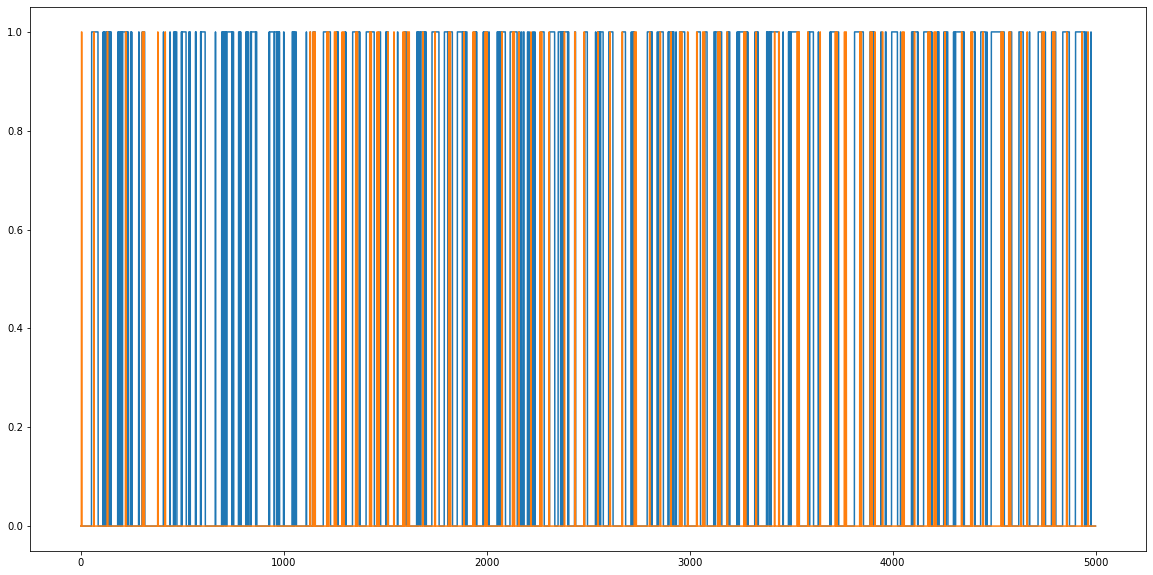

In [53]:
plt.plot(preds[:5000])
plt.plot(test_y[:5000])

In [43]:
from hmm import HMMRecalibration 

dayB        = DataStruct(pairs[i][1], alignScreens = True)

neural      = dayB.TX_continuous[:10000, :]
cursorPos   = dayB.cursorPos_continuous[:10000, :]
clickSignal = dayB.decClick_continuous[:10000]
targetPos   = dayB.targetPos_continuous[:10000, :]

rawDecTraj   = ref_decoder.predict(neural - neural.mean(axis = 0))
clickSignal  = ref_classifier.predict(neural - neural.mean(axis = 0))

# HMM setup:
probThreshold = 0.4
gridSize      = 20  
stayProb      = 0.9999
vmKappa       = 2


def getClickProbs_Offline(x):
    '''Offline click decoder probabilities.'''
    x         = x.squeeze()
    out       = np.zeros((len(x)))
    probs     = np.asarray([ 0.19116757, 0.0750774 , 0.01515152, 0.00245098, 0.00128205, 0.00424328, 0.02962963, 0.19936958, 0.42319055, 0.4822335, 0.4822335])
    dist_bins = np.asarray([-0.1,  53.60806253, 107.21612507, 160.8241876 , 214.43225013, 268.04031266, 321.6483752 , 375.25643773, 428.86450026, 482.47256279, 536.08062533])

    bin_idx   = np.digitize(x, dist_bins, right = True) - 1
    for i in range(len(x)):
        out[i]  = probs[int(bin_idx[i])]
        
    return out 
    

nStates       = gridSize**2                                                         # Number of discrete states 
stateTrans    = np.eye(nStates)*stayProb                                            # Define the state transition matrix, which assumes uniform transition probability of transitioning to new state
targLocs      = get_DiscreteTargetGrid(dayB, gridSize = gridSize, task = task)      # Target (x, y) location for each state

for x in range(nStates):
    idx                = np.setdiff1d(np.arange(nStates), x)
    stateTrans[x, idx] = (1-stayProb)/(nStates-1)
pStateStart = np.zeros((nStates,1)) + (1/nStates)
adjustKappa = lambda dist : 1 / (1 + np.exp(-1 * (dist - 70) * 0.5))

hmm = HMMRecalibration(stateTrans, targLocs, pStateStart, vmKappa, adjustKappa, getClickProb = getClickProbs_Offline)


In [44]:
targs        = hmm.viterbi_search(rawDecTraj, cursorPos)[0]
pTargs       = hmm.decode(rawDecTraj, cursorPos)[0]

targs_click  = hmm.viterbi_search(rawDecTraj, cursorPos, clickSignal)[0]
pTargs_click = hmm.decode(rawDecTraj, cursorPos, clickSignal)[0]

inferred_targs     = list()
inferred_targs.append(targLocs[targs.astype('int').flatten(), :]) 
inferred_targs.append(targLocs[targs_click.astype('int').flatten(), :]) 

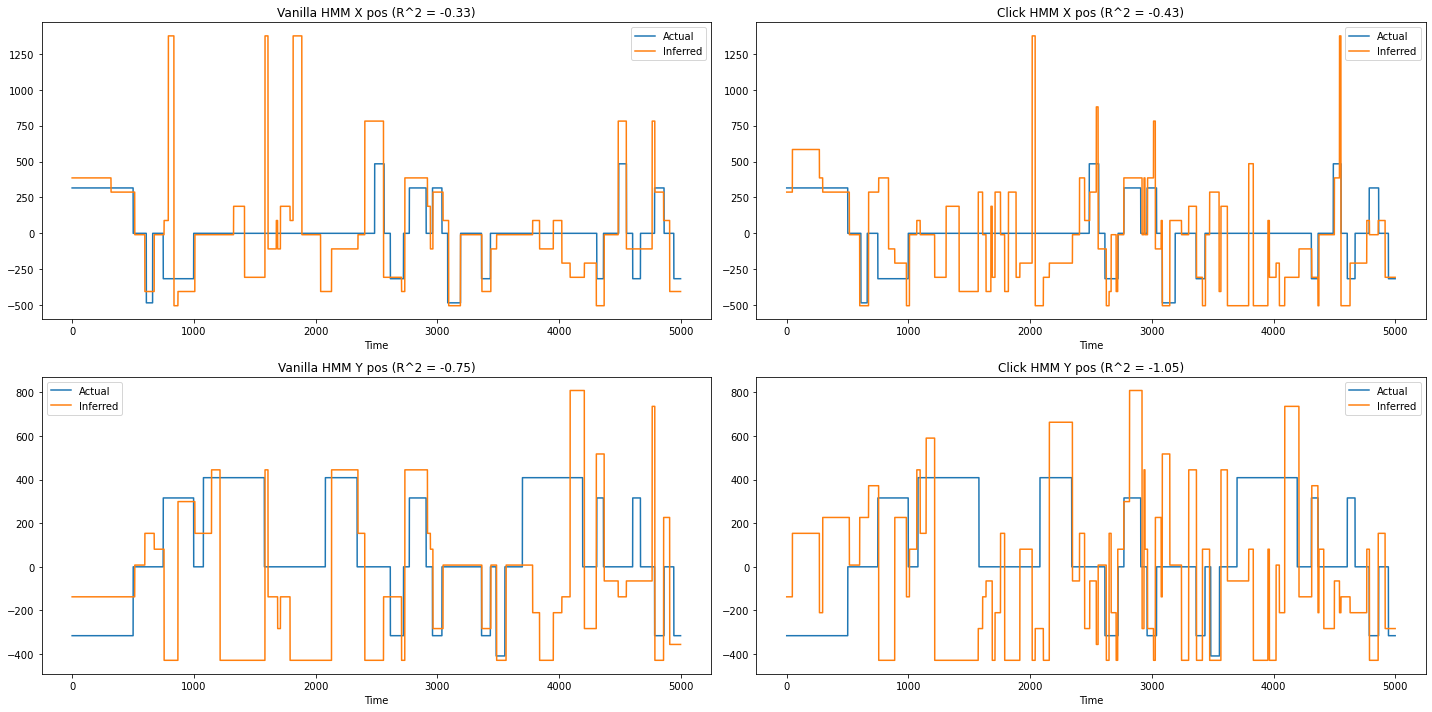

In [45]:
from sklearn.metrics import r2_score
figSize(10, 20)


dec_type = ['X pos', 'Y pos']
titles   = ['Vanilla HMM', 'Click HMM']
for i in range(2):  
    for j in range(2):
        plt.subplot(2, 2, i + (j * 2) + 1)
        plt.plot(targetPos[:5000, j], label = 'Actual')
        plt.plot(inferred_targs[i][:5000, j], label = 'Inferred')
        plt.xlabel('Time')
        plt.legend()
        corr = np.round(r2_score(targetPos[:, j], inferred_targs[i][:, j]), 2)
        plt.title(titles[i] + ' ' + dec_type[j] + ' (R^2 = ' + str(corr) + ')')
plt.tight_layout()

### Systematic comparison

Let's loop through all pairs of valid click sessions and measure target position inference using:
- vanilla HMM, where we decode using cursor decoder outputs and position alone
- click-augmented HMM, where we incorporate click signal into probabilities

For the click-augmented HMM, we can pass a method `getClickProbs()` to the HMM that defines the probability of a click given the distance to a target. If we use the historical (online) click likelihoods we don't too well - this is because the offline click decoder has a different behavior. We instead augment the obesrvations with the offline click decoder's characteristics (click likelihood as fxn of target), and see a performance boost. 

In [15]:
def getClickProbs_Online(x):
    '''Empirical click probabilities from historical (online) T5 click decoders.'''
    x_mat         = np.vstack([x**i for i in range(5)])    
    coefs         = [ 0.00000000e+00, -1.33178954e-03,  5.05269183e-06, -6.29799392e-09, 2.57353522e-12]
    out           = x_mat.T.dot(coefs) + 0.13775515475153405
    out[x > 1000] = .12
    
    return out

def getClickProbs_Offline(x):
    '''Offline click decoder probabilities.'''
    x         = x.squeeze()
    out       = np.zeros((len(x)))
    probs     = np.asarray([ 0.19116757, 0.0750774 , 0.01515152, 0.00245098, 0.00128205, 0.00424328, 0.02962963, 0.19936958, 0.42319055, 0.4822335, 0.4822335])
    dist_bins = np.asarray([-0.1,  53.60806253, 107.21612507, 160.8241876 , 214.43225013, 268.04031266, 321.6483752 , 375.25643773, 428.86450026, 482.47256279, 536.08062533])

    bin_idx   = np.digitize(x, dist_bins, right = True) - 1
    out       = probs[bin_idx]
    
    return out 


def adjustKappa(dist):
    coef = 1 / (1 + np.exp(-1 * (dist - 70) * 0.05))
    return coef 

In [16]:
# Get initial day performance and decoder:
train_frac = 0.5
task       = None
sigma      = None
blocks     = None

# HMM setup:
probThreshold = 0.4
gridSize      = 20  
stayProb      = 0.9999
vmKappa       = 2


#----------------------------------------

nStates       = gridSize**2                                                         # Number of discrete states 
stateTrans    = np.eye(nStates)*stayProb                                            # Define the state transition matrix, which assumes uniform transition probability of transitioning to new state

for x in range(nStates):
    idx                = np.setdiff1d(np.arange(nStates), x)
    stateTrans[x, idx] = (1-stayProb)/(nStates-1)
pStateStart = np.zeros((nStates,1)) + (1/nStates)


corrs = np.zeros((n_pairs, 2, 2)) # pairs x HMMs x coordinates
for i in range(n_pairs):

    dayA = DataStruct(pairs[i][0], alignScreens = True)
    dayB = DataStruct(pairs[i][1], alignScreens = True)
    
    targLocs      = get_DiscreteTargetGrid(dayB, gridSize = gridSize, task = task)      # Target (x, y) location for each state



    train_x, test_x, train_y, test_y  = getTrainTest(dayA, train_frac = train_frac, sigma = sigma, task = task, blocks = blocks, return_flattened = True)
    ref_scores, ref_decoder           = traintest_DecoderSupervised([train_x], [test_x], [train_y], [test_y])

    train_x, test_x, train_y, test_y  = get_T5_ClickTrainTest(dayA, train_frac = train_frac)
    ref_classifier                    = ClickDecoder(window = 20, n_components = 5).train(train_x - train_x.mean(axis = 0), train_y)



    neural      = dayB.TX_continuous[:10000, :]
    cursorPos   = dayB.cursorPos_continuous[:10000, :]
    clickSignal = dayB.decClick_continuous[:10000]
    targetPos   = dayB.targetPos_continuous[:10000, :]

    rawDecTraj   = ref_decoder.predict(neural - neural.mean(axis = 0))
    clickSignal  = ref_classifier.predict(neural - neural.mean(axis = 0))

    
    targs        = hmmviterbi_vonmises(rawDecTraj, stateTrans, targLocs, cursorPos, pStateStart, vmKappa = vmKappa, adjustKappa= adjustKappa)[0]
    pTargs       = hmmdecode_vonmises(rawDecTraj, stateTrans, targLocs, cursorPos,  pStateStart, vmKappa = vmKappa, adjustKappa= adjustKappa)[0]

    targs_click  = click_hmmviterbi_vonmises(rawDecTraj, stateTrans, targLocs, cursorPos, clickSignal, getClickProbs_Offline, pStateStart, vmKappa, adjustKappa= adjustKappa)[0]

    
    inferred_vanilla = targLocs[targs.astype('int').flatten(), :]
    inferred_click   = targLocs[targs_click.astype('int').flatten(), :]
    
    for coord in range(2):
        corrs[i, 0, coord] = r2_score(targetPos[:, coord], inferred_vanilla[:, coord])
        corrs[i, 1, coord] = r2_score(targetPos[:, coord], inferred_click[:, coord])

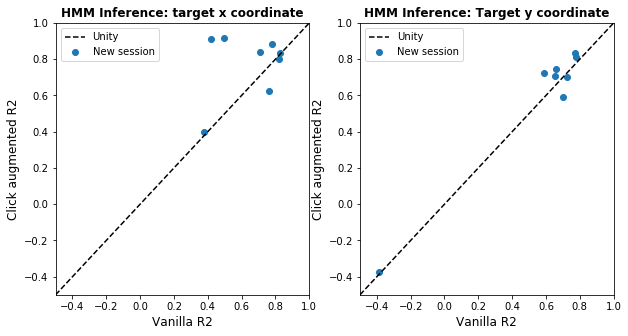

In [17]:
from lineplots import comparisonScatterPlot
figSize(5, 10)

titles = ['target x coordinate', 'Target y coordinate']

for coord in range(2):
    plt.subplot(1, 2, coord + 1)
    comparisonScatterPlot(corrs[:, 0, coord], corrs[:, 1, coord], xy_lims = [-0.5, 1])
    plt.xlabel('Vanilla R2', fontsize = 12)
    plt.ylabel('Click augmented R2', fontsize = 12)
    plt.legend(['Unity', 'New session'])
    plt.title('HMM Inference: ' + titles[coord], fontweight = 'bold')